# Knowledge Engineering - Team Phoenix

In [ ]:
!pip install opendatasets --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karmakarabhishek5","key":"36b4a526001d0aea0dbb0308eec30991"}'}

In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d uciml/electric-power-consumption-data-set

 88% 17.0M/19.4M [00:01<00:00, 16.2MB/s]
100% 19.4M/19.4M [00:01<00:00, 10.9MB/s]


In [ ]:
!ls

electric-power-consumption-data-set.zip  kaggle.json  sample_data


In [ ]:
!unzip electric-power-consumption-data-set.zip

Archive:  electric-power-consumption-data-set.zip
  inflating: household_power_consumption.txt  


In [ ]:
!ls

electric-power-consumption-data-set.zip  kaggle.json
household_power_consumption.txt		 sample_data


Step 0 : Import Necessary Packages

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

1) Note that data include 'nan' and '?' as a string. I converted both to numpy nan in importing stage (above) and treated both of them the same.

2) I merged two columns 'Date' and 'Time' to 'dt'.

3) I also converted in the above, the data to time-series type, by taking index to be the time.


In [ ]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [ ]:
df = df.fillna(df.mean())
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [ ]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

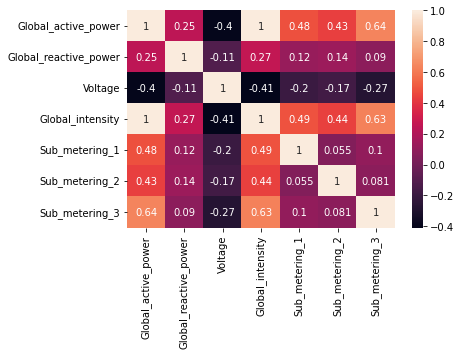

In [ ]:
sns.heatmap(df.corr(), annot=True)

Step 3: LSTM Data Preparation and fitting

In [ ]:
## The LSTM neural network has been selected because:
## It is best suited for large data, time-series, and sequential problem. 
## In the first step, we will frame  the problem to predict the Global_active_power.

In [ ]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

# sns.heatmap(df.isnull(), yticklabels=False, cmap='viridis')

print('Length = ', len(df))


# Removing Outlier
import numpy as np
for cols in df.iloc[:,2:].columns:
    print(cols)
    for x in [cols]:
        q75,q25 = np.percentile(df.loc[:,x],[75,25])
        intr_qr = q75-q25
        
        max1 = q75+(1.5*intr_qr)
        min1 = q25-(1.5*intr_qr)
        
        df.loc[df[x] < min1,x] = np.NaN
        df.loc[df[x] > max1,x] = np.NaN



df = df.fillna(df.mean())
df.isnull().sum()   

df = df[['Global_active_power', 'Global_reactive_power', 'Voltage','Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]

Length =  2075259
Voltage
Global_intensity
Sub_metering_1
Sub_metering_2
Sub_metering_3


In [ ]:
# We will frame the supervised learning problem as predicting the Global_active_power at the current time (t) 
# given the Global_active_power measurement and other features at the prior time step

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff.shift(i))
        if i==0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1)) for j in range(n_vars)]        
        agg = pd.concat(cols, axis=1)
        agg.columns = names
        if dropnan:
            agg.dropna(inplace=True)
        return agg

In [ ]:
from sklearn.preprocessing import MinMaxScaler

df_resample = df.copy()
values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

print(df_resample.shape)
print("-----------------------------------------------------------")
print(scaled)
print("-----------------------------------------------------------")

reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
print(reframed.head())
print("-----------------------------------------------------------")
print(reframed.tail())

(2075259, 7)
-----------------------------------------------------------
[[0.37479631 0.30071942 0.37609047 ... 0.0125     0.         0.5483871 ]
 [0.47836321 0.31366906 0.33699515 ... 0.0125     0.         0.51612903]
 [0.47963064 0.35827338 0.32600969 ... 0.025      0.         0.5483871 ]
 ...
 [0.0780373  0.         0.53699515 ... 0.         0.         0.        ]
 [0.07767518 0.         0.53311793 ... 0.         0.         0.        ]
 [0.07749412 0.         0.52827141 ... 0.         0.         0.        ]]
-----------------------------------------------------------
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.374796   0.300719   0.376090   0.377593     0.0125        0.0   
2   0.478363   0.313669   0.336995   0.473029     0.0125        0.0   
3   0.479631   0.358273   0.326010   0.473029     0.0250        0.0   
4   0.480898   0.361151   0.340549   0.473029     0.0125        0.0   
5   0.325005   0.379856   0.403231   0.323651     0.0125        0.0 

In [ ]:
kkk = pd.DataFrame(reframed.head())
kkk.rename(columns = {'var1(t-1)':'Global_active_power(t-1)', 'var2(t-1)':'Global_reactive_power(t-1)', 'var3(t-1)':'Voltage(t-1)', 'var4(t-1)':'Global_intensity(t-1)', 
                      'var5(t-1)':'Sub_metering_2','var6(t-1)': 'Sub_metering_1(t-1)', 'var7(t-1)': 'Sub_metering_3(t-1)', 'var1(t)': 'Global_active_power(t)'},inplace = True)
kkk

,Global_active_power(t-1),Global_reactive_power(t-1),Voltage(t-1),Global_intensity(t-1),Sub_metering_2,Sub_metering_1(t-1),Sub_metering_3(t-1),Global_active_power(t)
1,0.374796,0.300719,0.376090,0.377593,0.0125,0.0,0.548387,0.478363
2,0.478363,0.313669,0.336995,0.473029,0.0125,0.0,0.516129,0.479631
3,0.479631,0.358273,0.326010,0.473029,0.0250,0.0,0.548387,0.480898
4,0.480898,0.361151,0.340549,0.473029,0.0125,0.0,0.548387,0.325005
5,0.325005,0.379856,0.403231,0.323651,0.0125,0.0,0.548387,0.311787


In [ ]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var1(t)'],
      dtype='object')

In [ ]:
scaled.shape

(2075259, 7)

In [ ]:
reframed.shape

(2075258, 8)

In [ ]:

# Data spliting into train and test data series. Only 30000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 1660206 # 80% of 2075258
train = values[:n_train_time, :]
test = values[n_train_time:, :]

# split into input and outputs
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [ ]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(1660206, 1, 7) (1660206,) (415052, 1, 7) (415052,)


## **LSTM model setting :-**

(1) 100 neurons in the first visible layer

(2) dropout 10%

(3) 30 neuron for Dense Layer and then 1 neuron in the output layer for predicting Global_active_power

(4) The input shape will be 1 time step with 7 features

(5) The mean_squared_error loss function and the efficient adam version of stochastic gradient descent

(6) The model will be fit for 25 training epochs with a batch size of 70.

Epoch 1/10
23718/23718 - 183s - loss: 7.9685e-04 - val_loss: 3.8139e-04 - 183s/epoch - 8ms/step
Epoch 2/10
23718/23718 - 176s - loss: 6.3327e-04 - val_loss: 3.7450e-04 - 176s/epoch - 7ms/step
Epoch 3/10
23718/23718 - 174s - loss: 6.2258e-04 - val_loss: 3.6964e-04 - 174s/epoch - 7ms/step
Epoch 4/10
23718/23718 - 165s - loss: 6.1250e-04 - val_loss: 3.6890e-04 - 165s/epoch - 7ms/step
Epoch 5/10
23718/23718 - 163s - loss: 6.0233e-04 - val_loss: 3.6288e-04 - 163s/epoch - 7ms/step
Epoch 6/10
23718/23718 - 163s - loss: 6.0063e-04 - val_loss: 3.6492e-04 - 163s/epoch - 7ms/step
Epoch 7/10
23718/23718 - 173s - loss: 5.9879e-04 - val_loss: 3.6321e-04 - 173s/epoch - 7ms/step
Epoch 8/10
23718/23718 - 174s - loss: 5.9679e-04 - val_loss: 3.6264e-04 - 174s/epoch - 7ms/step
Epoch 9/10
23718/23718 - 172s - loss: 5.9269e-04 - val_loss: 3.5898e-04 - 172s/epoch - 7ms/step
Epoch 10/10
23718/23718 - 174s - loss: 5.9366e-04 - val_loss: 3.6206e-04 - 174s/epoch - 7ms/step


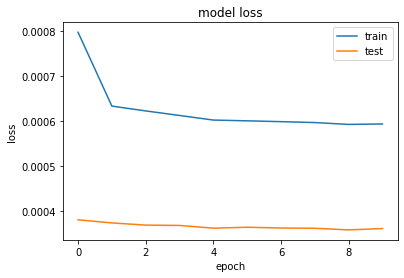

12971/12971 [==============================] - 26s 2ms/step


In [ ]:
# GLOBAL ACTIVE POWER
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

model1 = Sequential()
model1.add(LSTM(100, activation = 'relu', input_shape=(train_x.shape[1], train_x.shape[2])))
# model1.add(Dropout(0.1))
model1.add(Dense(1000))
model1.add(Dense(100))
model1.add(Dense(1))
model1.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model1.fit(train_x, train_y, epochs=25, batch_size=70, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model1.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


Mean Absolute Error: 0.095
Mean Squared Error:  0.044
Test RMSE: 0.210
R2 Score:  0.9420032647825894


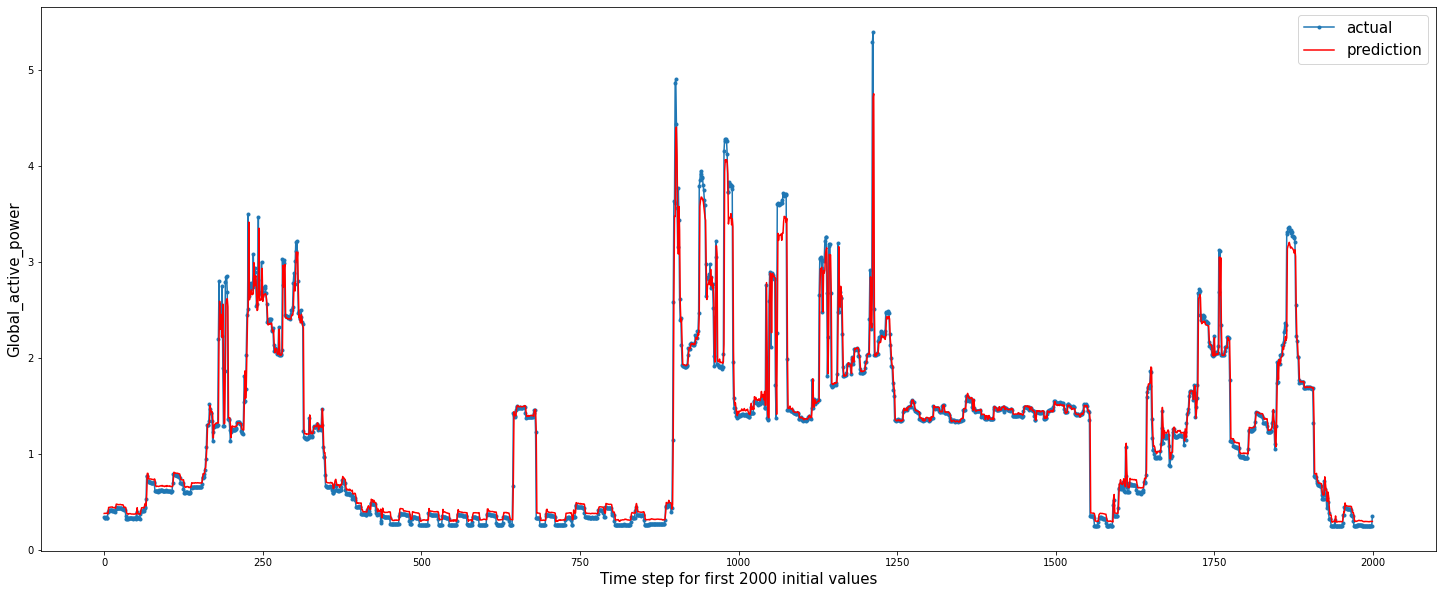

In [ ]:
# ERROR METRICES
print('Mean Absolute Error: %.3f' % mean_absolute_error(inv_y, inv_yhat)) 
print('Mean Squared Error:  %.3f' % mean_squared_error(inv_y, inv_yhat)) 
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('R2 Score: ', r2_score(inv_y, inv_yhat))


# Note that, we have resampled the database into hour, so, every time step is one hour. We try first to check the prediction in 500 hours.
aa=[x for x in range(2000)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:2000], marker='.', label="actual")
plt.plot(aa, inv_yhat[:2000], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 2000 initial values', size=15)
plt.legend(fontsize=15)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


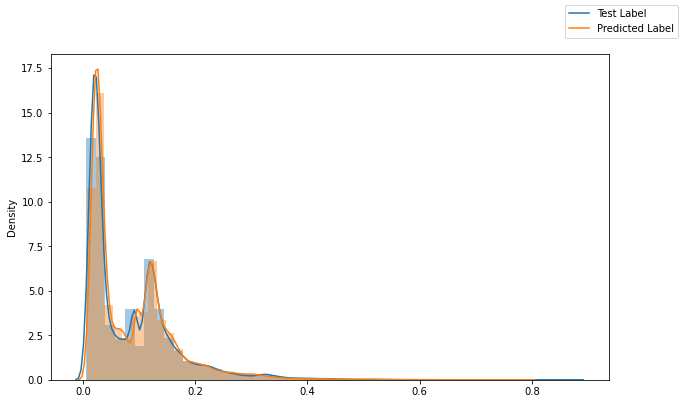

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(test_y)
sns.distplot(yhat)
fig.legend(labels=['Test Label','Predicted Label'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


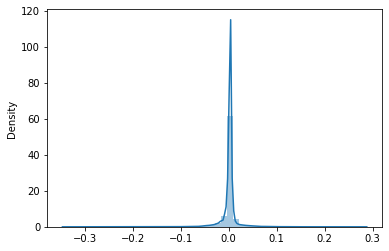

In [ ]:
sns.distplot(yhat-test_y)

In [ ]:
print("Difference of Variance = ", abs(np.var(test_y) - np.var(yhat)))

Difference of Variance =  0.0005803708769945353


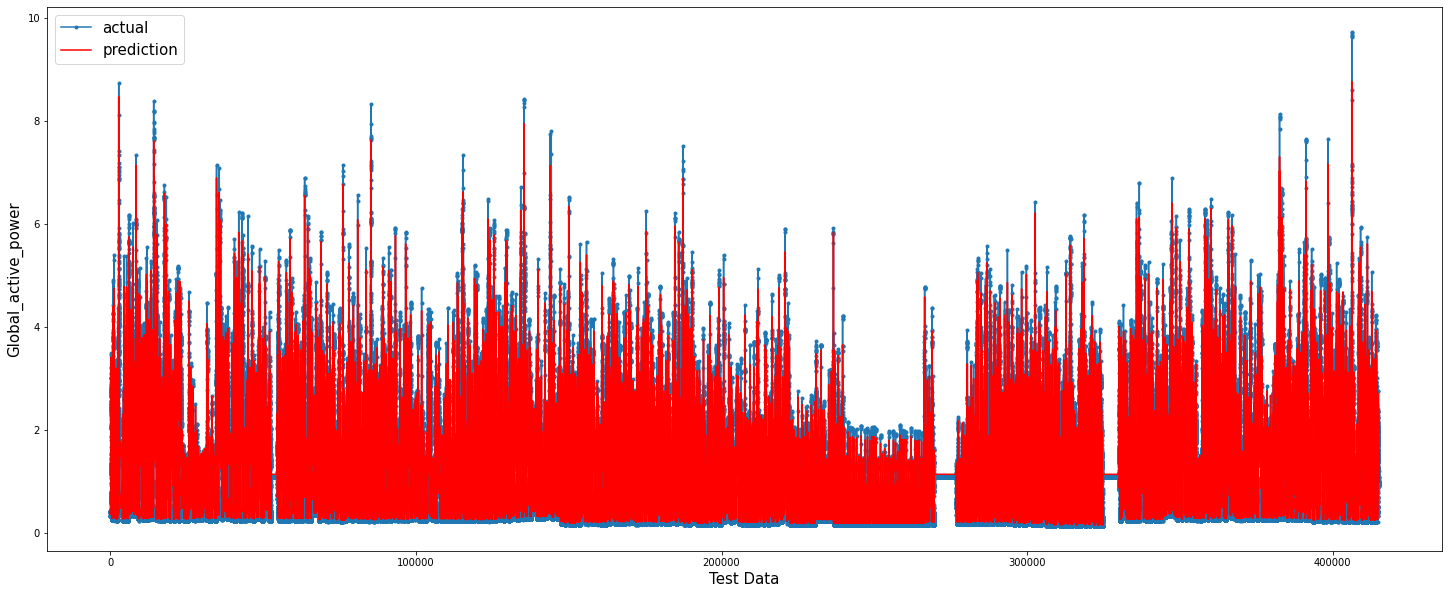

In [ ]:
aa=[x for x in range(len(test_y))]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y, marker='.', label="actual")
plt.plot(aa, inv_yhat, 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Test Data', size=15)
plt.legend(fontsize=15)
plt.show()

# Sub_metering_3

Now, let's try to fit and predict the Sub_metering_3

(2075259, 7)
[[0.5483871  0.37479631 0.30071942 ... 0.37759336 0.0125     0.        ]
 [0.51612903 0.47836321 0.31366906 ... 0.47302905 0.0125     0.        ]
 [0.5483871  0.47963064 0.35827338 ... 0.47302905 0.025      0.        ]
 ...
 [0.         0.0780373  0.         ... 0.0746888  0.         0.        ]
 [0.         0.07767518 0.         ... 0.0746888  0.         0.        ]
 [0.         0.07749412 0.         ... 0.0746888  0.         0.        ]]
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.548387   0.374796   0.300719   0.376090   0.377593     0.0125   
2   0.516129   0.478363   0.313669   0.336995   0.473029     0.0125   
3   0.548387   0.479631   0.358273   0.326010   0.473029     0.0250   
4   0.548387   0.480898   0.361151   0.340549   0.473029     0.0125   
5   0.548387   0.325005   0.379856   0.403231   0.323651     0.0125   

   var7(t-1)   var1(t)  
1        0.0  0.516129  
2        0.0  0.548387  
3        0.0  0.548387  
4        0.0  0.

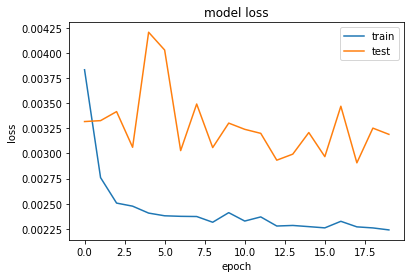

12971/12971 [==============================] - 23s 2ms/step


In [ ]:
df = df[['Sub_metering_3','Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1']]

from sklearn.preprocessing import MinMaxScaler

df_resample = df.copy()
values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

print(df_resample.shape)
print(scaled)

reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
print(reframed.head())

# Data spliting into train and test data series. Only 1660206 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 1660206
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))


from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model7 = Sequential()
model7.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
model7.add(Dense(5000))
model7.add(Dense(500))
model7.add(Dropout(0.1))
model7.add(Dense(1))
model7.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model7.fit(train_x, train_y, epochs=20, batch_size=100, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model7.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

Mean Absolute Error: 0.870
Mean Squared Error:  3.066
Test RMSE: 1.751
R2 Score:  0.9566728556242929


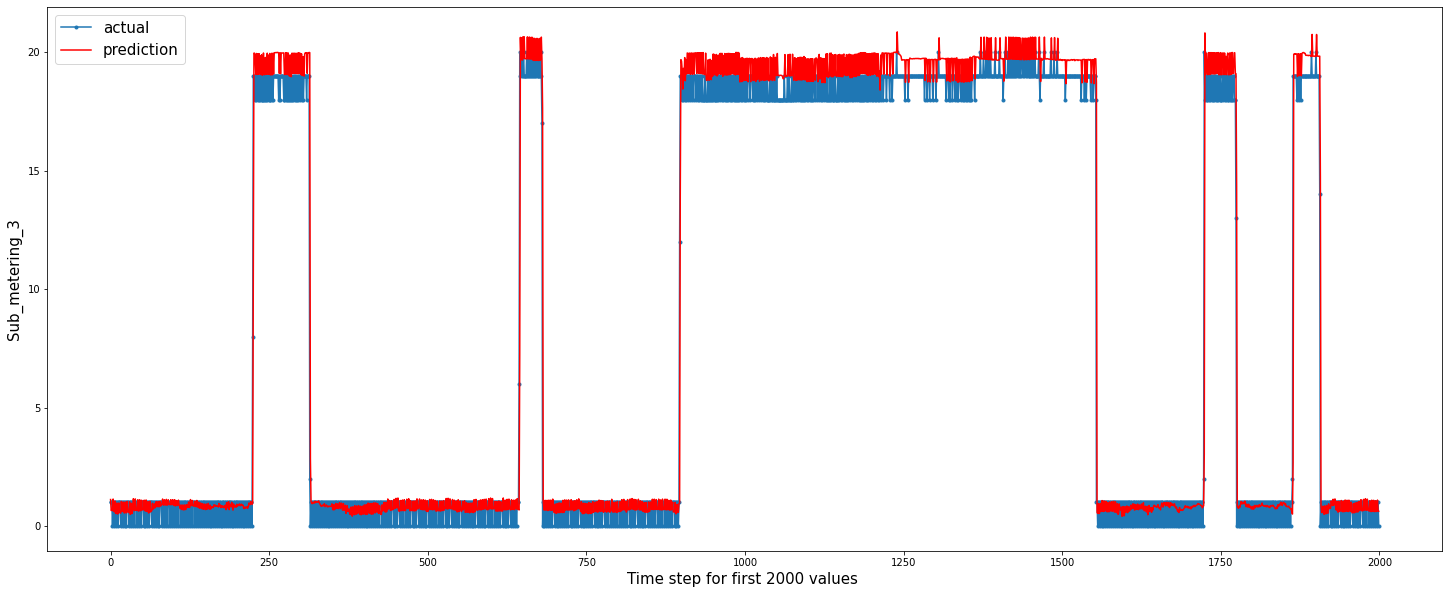

In [ ]:
# ERROR METRICES
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
print('Mean Absolute Error: %.3f' % mean_absolute_error(inv_y, inv_yhat)) 
print('Mean Squared Error:  %.3f' % mean_squared_error(inv_y, inv_yhat)) 
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('R2 Score: ', r2_score(inv_y, inv_yhat))

# Note that, we have resampled the database into hour, so, every time step is one hour. We try first to check the prediction in first 500.
aa=[x for x in range(2000)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:2000], marker='.', label="actual")
plt.plot(aa, inv_yhat[:2000], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 2000 values ', size=15)
plt.legend(fontsize=15)
plt.show()


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


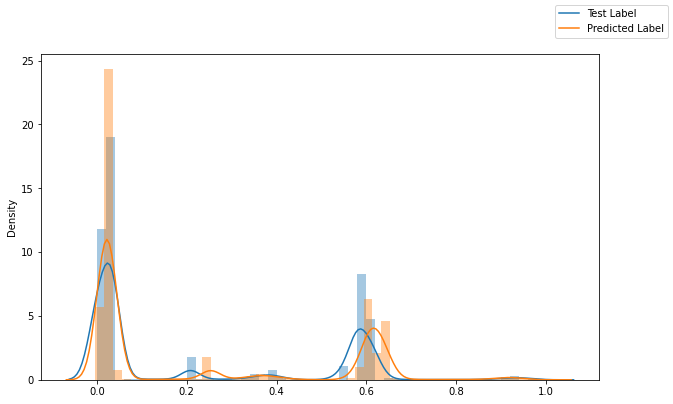

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(test_y)
sns.distplot(yhat)
fig.legend(labels=['Test Label','Predicted Label'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


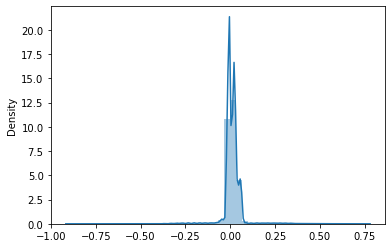

In [ ]:
sns.distplot(yhat-test_y)

In [ ]:
print("Difference of Variance = ", abs(np.var(test_y) - np.var(yhat)))

Difference of Variance =  0.005018527867984485


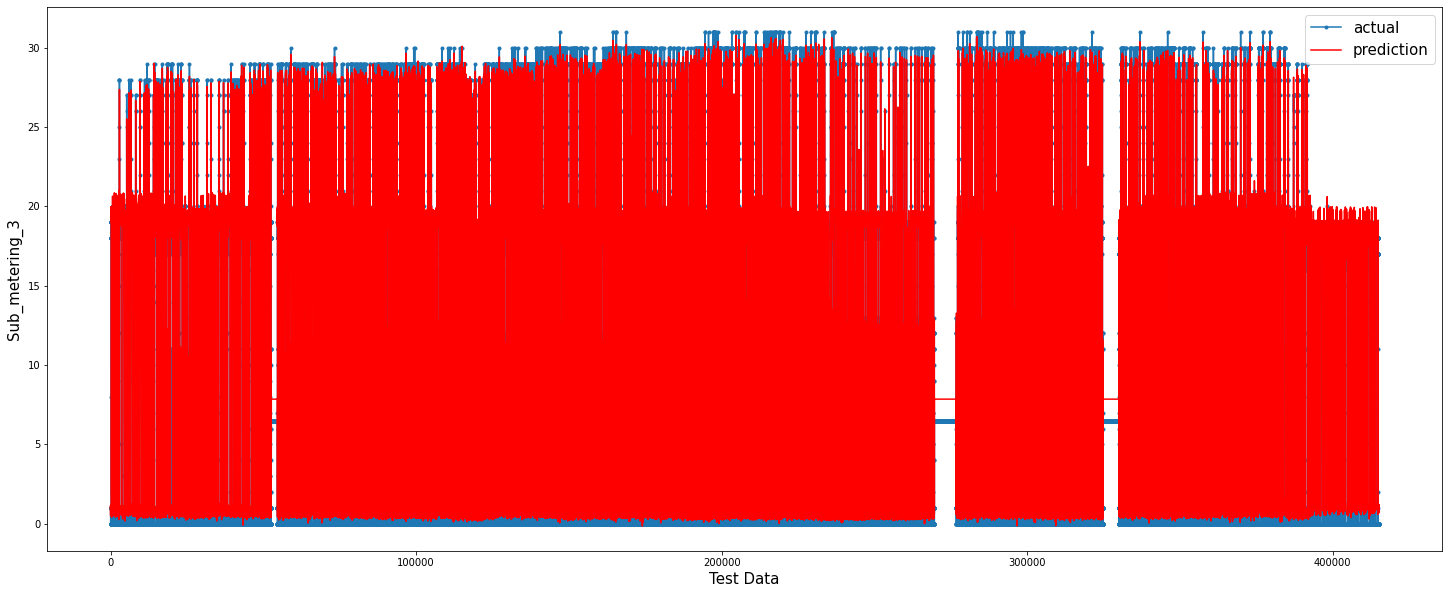

In [ ]:
kk = len(inv_yhat)
aa=[x for x in range(kk)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:kk], marker='.', label="actual")
plt.plot(aa, inv_yhat[:kk], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Test Data', size=15)
plt.legend(fontsize=15)
plt.show()

# Global Reactive Power

Now, let's try to fit and predict the Global Reactive Power

Voltage
Global_intensity
Sub_metering_1
Sub_metering_2
Sub_metering_3
(2075259, 7)
[[0.30071942 0.5483871  0.37479631 ... 0.37759336 0.0125     0.        ]
 [0.31366906 0.51612903 0.47836321 ... 0.47302905 0.0125     0.        ]
 [0.35827338 0.5483871  0.47963064 ... 0.47302905 0.025      0.        ]
 ...
 [0.         0.         0.0780373  ... 0.0746888  0.         0.        ]
 [0.         0.         0.07767518 ... 0.0746888  0.         0.        ]
 [0.         0.         0.07749412 ... 0.0746888  0.         0.        ]]
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.300719   0.548387   0.374796   0.376090   0.377593     0.0125   
2   0.313669   0.516129   0.478363   0.336995   0.473029     0.0125   
3   0.358273   0.548387   0.479631   0.326010   0.473029     0.0250   
4   0.361151   0.548387   0.480898   0.340549   0.473029     0.0125   
5   0.379856   0.548387   0.325005   0.403231   0.323651     0.0125   

   var7(t-1)   var1(t)  
1        0.0  0.31366

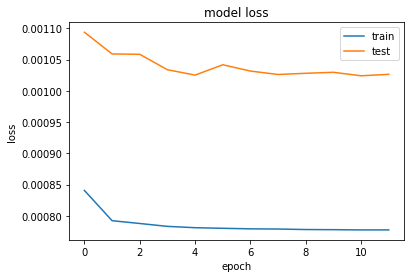

12971/12971 [==============================] - 23s 2ms/step


In [ ]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

# sns.heatmap(df.isnull(), yticklabels=False, cmap='viridis')

len(df)

import numpy as np
for cols in df.iloc[:,2:].columns:
    print(cols)
    for x in [cols]:
        q75,q25 = np.percentile(df.loc[:,x],[75,25])
        intr_qr = q75-q25
        
        max1 = q75+(1.5*intr_qr)
        min1 = q25-(1.5*intr_qr)
        
        df.loc[df[x] < min1,x] = np.NaN
        df.loc[df[x] > max1,x] = np.NaN

# sns.heatmap(df.isnull(), yticklabels=False, cmap='viridis')    



df = df.fillna(df.mean())
df.isnull().sum()



df = df[['Global_reactive_power', 'Sub_metering_3','Global_active_power',  'Voltage',
       'Global_intensity', 'Sub_metering_2', 'Sub_metering_1']]


df_resample = df.copy()
values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

print(df_resample.shape)
print(scaled)

reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
print(reframed.head())

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 1660206
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))





from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import MinMaxScaler


model2 = Sequential()
model2.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
# model2.add(Dropout(0.1))
model2.add(Dense(1000))
model2.add(Dense(100))
model2.add(Dense(1))
model2.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model2.fit(train_x, train_y, epochs=12, batch_size=100, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model2.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]


Mean Absolute Error: 0.024
Mean Squared Error:  0.002
Test RMSE: 0.045
R2 Score:  0.8441778163126122


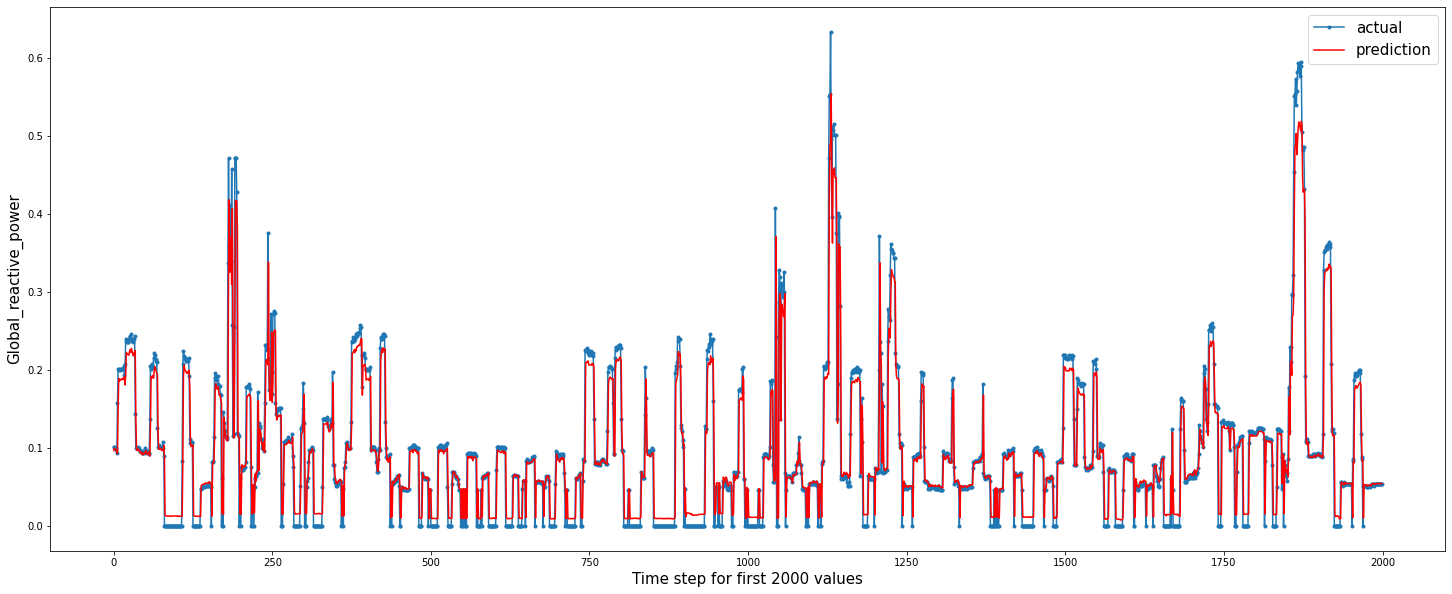

In [ ]:
# ERROR METRICES
print('Mean Absolute Error: %.3f' % mean_absolute_error(inv_y, inv_yhat)) 
print('Mean Squared Error:  %.3f' % mean_squared_error(inv_y, inv_yhat)) 
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('R2 Score: ', r2_score(inv_y, inv_yhat))

# Note that, we have resampled the database into hour, so, every time step is one hour. We try first to check the prediction in 500 hours.
aa=[x for x in range(2000)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:2000], marker='.', label="actual")
plt.plot(aa, inv_yhat[:2000], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 2000 values', size=15)
plt.legend(fontsize=15)
plt.show()


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


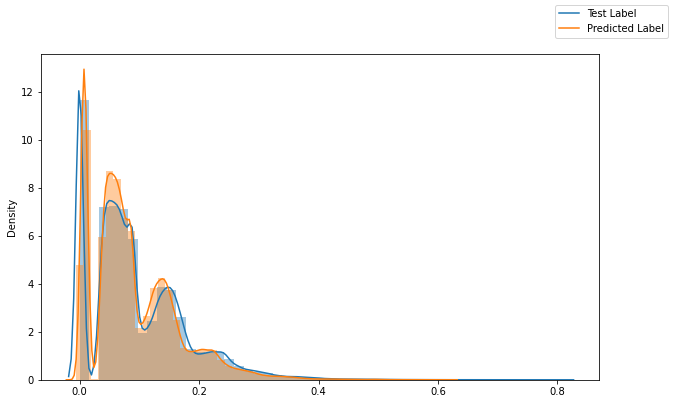

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(test_y)
sns.distplot(yhat)
fig.legend(labels=['Test Label','Predicted Label'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


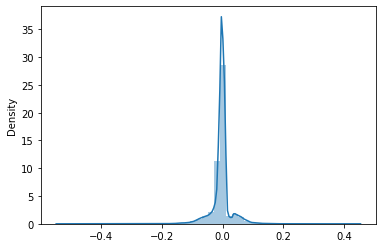

In [ ]:
sns.distplot(yhat-test_y)

In [ ]:
print("Difference of Variance = ", abs(np.var(test_y) - np.var(yhat)))

Difference of Variance =  0.0013594362171600273


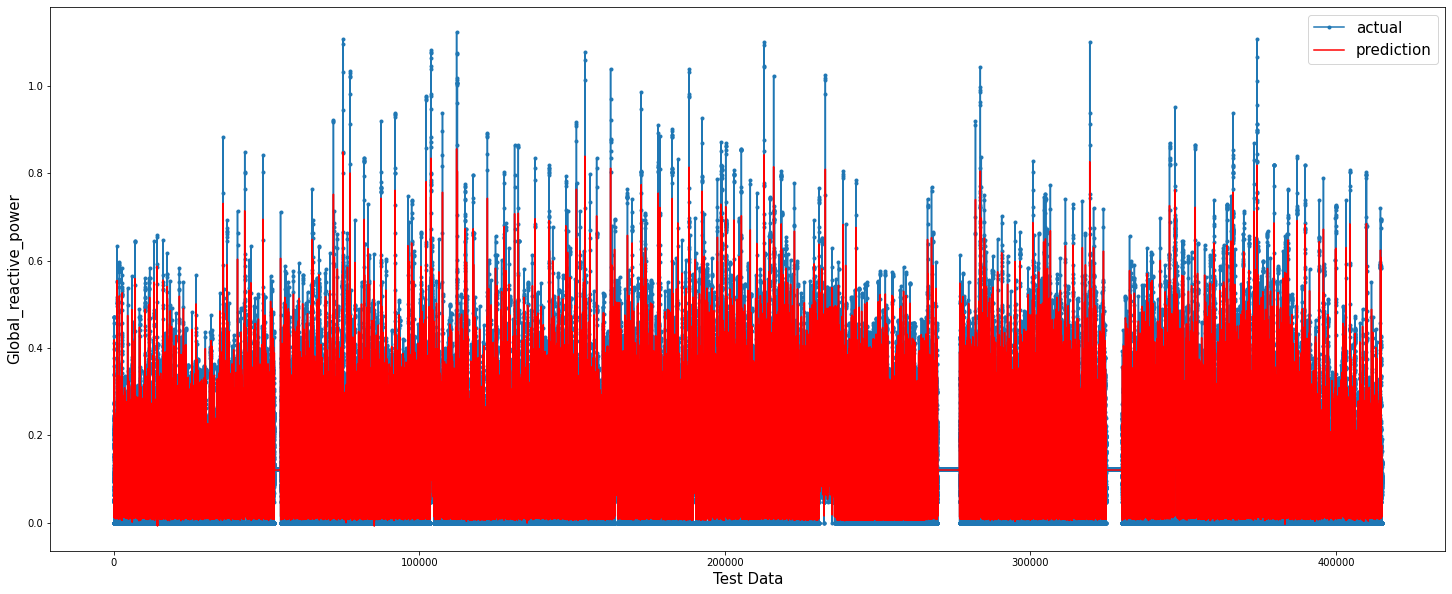

In [ ]:
kk = len(inv_yhat)
aa=[x for x in range(kk)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:kk], marker='.', label="actual")
plt.plot(aa, inv_yhat[:kk], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Test Data', size=15)
plt.legend(fontsize=15)
plt.show()

# Predict Voltage

Voltage
Global_intensity
Sub_metering_1
Sub_metering_2
Sub_metering_3
(2075259, 7)
[[0.37609047 0.37479631 0.30071942 ... 0.0125     0.         0.5483871 ]
 [0.33699515 0.47836321 0.31366906 ... 0.0125     0.         0.51612903]
 [0.32600969 0.47963064 0.35827338 ... 0.025      0.         0.5483871 ]
 ...
 [0.53699515 0.0780373  0.         ... 0.         0.         0.        ]
 [0.53311793 0.07767518 0.         ... 0.         0.         0.        ]
 [0.52827141 0.07749412 0.         ... 0.         0.         0.        ]]
   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.376090   0.374796   0.300719   0.377593     0.0125        0.0   
2   0.336995   0.478363   0.313669   0.473029     0.0125        0.0   
3   0.326010   0.479631   0.358273   0.473029     0.0250        0.0   
4   0.340549   0.480898   0.361151   0.473029     0.0125        0.0   
5   0.403231   0.325005   0.379856   0.323651     0.0125        0.0   

   var7(t-1)   var1(t)  
1   0.548387  0.33699

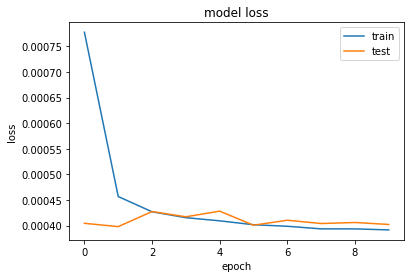

12971/12971 [==============================] - 23s 2ms/step


In [ ]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')


# Removing Outlier
import numpy as np
for cols in df.iloc[:,2:].columns:
    print(cols)
    for x in [cols]:
        q75,q25 = np.percentile(df.loc[:,x],[75,25])
        intr_qr = q75-q25
        
        max1 = q75+(1.5*intr_qr)
        min1 = q25-(1.5*intr_qr)
        
        df.loc[df[x] < min1,x] = np.NaN
        df.loc[df[x] > max1,x] = np.NaN



df = df.fillna(df.mean())

df = df[['Voltage', 'Global_active_power',  'Global_reactive_power', 'Global_intensity', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]

df_resample = df.copy()
values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

print(df_resample.shape)
print(scaled)

reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
print(reframed.head())

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 1660206
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))



from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model3 = Sequential()
model3.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
# model3.add(Dropout(0.1))
model3.add(Dense(2000))
model3.add(Dense(100))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model3.fit(train_x, train_y, epochs=10, batch_size=100, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model3.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

Mean Absolute Error: 0.468
Mean Squared Error:  0.385
Test RMSE: 0.621
R2 Score:  0.9455581109024984


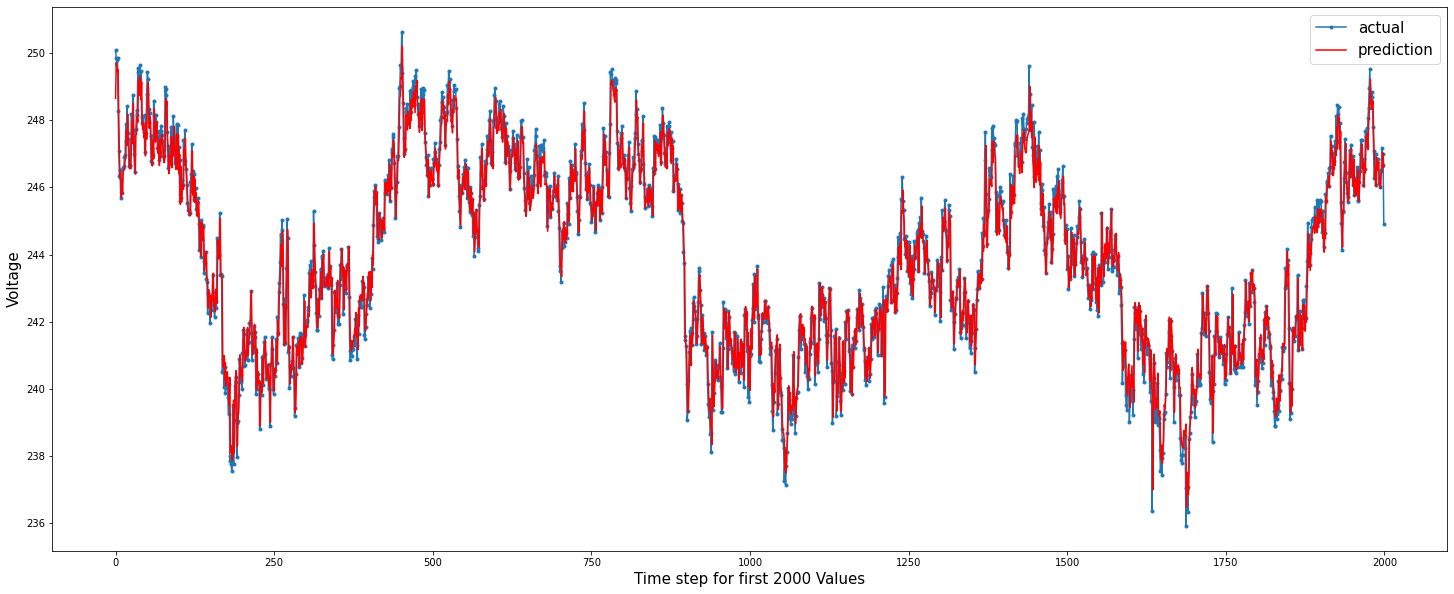

In [ ]:
# ERROR METRICES
print('Mean Absolute Error: %.3f' % mean_absolute_error(inv_y, inv_yhat)) 
print('Mean Squared Error:  %.3f' % mean_squared_error(inv_y, inv_yhat)) 
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('R2 Score: ', r2_score(inv_y, inv_yhat))


# Note that, we have resampled the database into hour, so, every time step is one hour. We try first to check the prediction in 500 hours.
aa=[x for x in range(2000)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:2000], marker='.', label="actual")
plt.plot(aa, inv_yhat[:2000], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Time step for first 2000 Values', size=15)
plt.legend(fontsize=15)
plt.show()


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


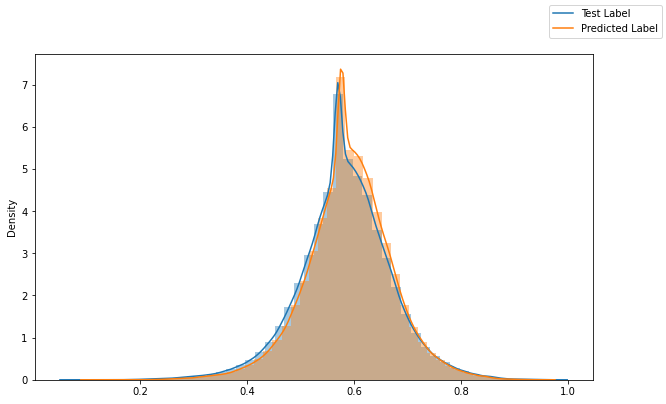

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(test_y)
sns.distplot(yhat)
fig.legend(labels=['Test Label','Predicted Label'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


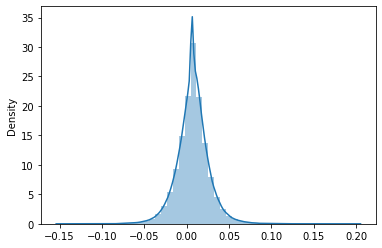

In [ ]:
sns.distplot(yhat-test_y)

In [ ]:
print("Difference of Variance = ", abs(np.var(test_y) - np.var(yhat)))

Difference of Variance =  0.0009575358325377894


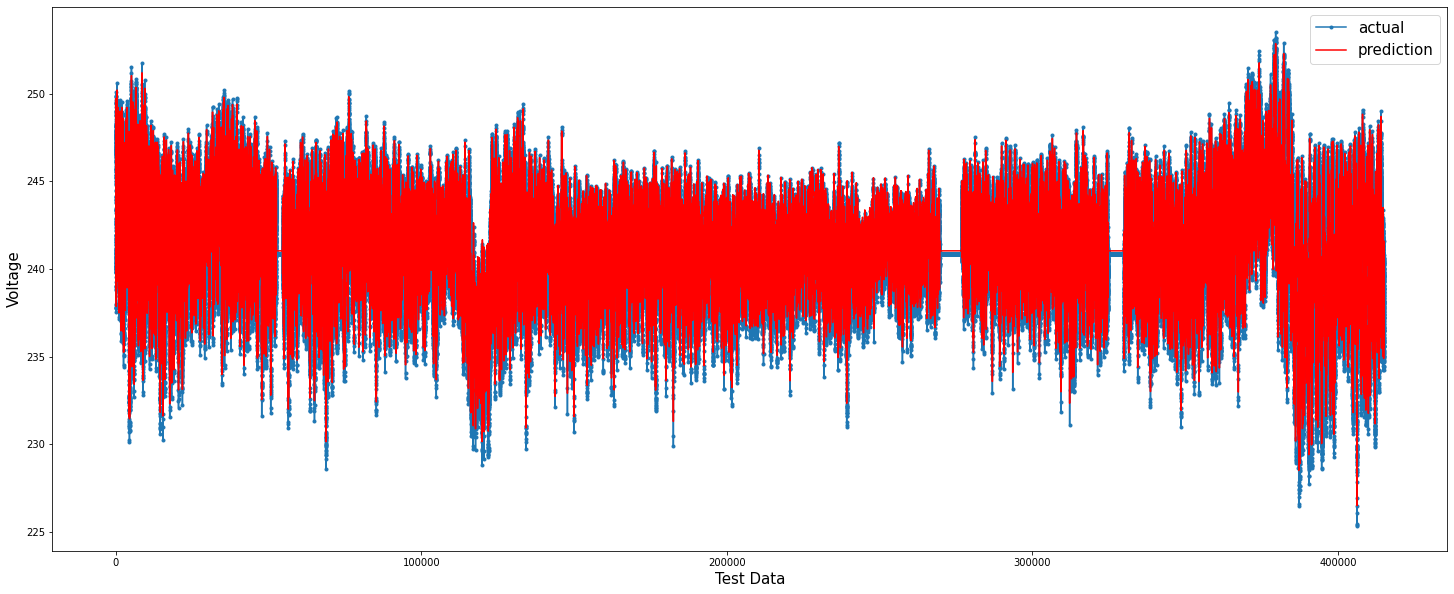

In [ ]:
kk = len(inv_yhat)
aa=[x for x in range(kk)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:kk], marker='.', label="actual")
plt.plot(aa, inv_yhat[:kk], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Test Data', size=15)
plt.legend(fontsize=15)
plt.show()

# Global Intensity

Epoch 1/10
16603/16603 - 62s - loss: 7.4728e-04 - val_loss: 3.8550e-04 - 62s/epoch - 4ms/step
Epoch 2/10
16603/16603 - 60s - loss: 6.2488e-04 - val_loss: 3.7081e-04 - 60s/epoch - 4ms/step
Epoch 3/10
16603/16603 - 58s - loss: 6.0495e-04 - val_loss: 3.7658e-04 - 58s/epoch - 3ms/step
Epoch 4/10
16603/16603 - 62s - loss: 6.0103e-04 - val_loss: 3.7312e-04 - 62s/epoch - 4ms/step
Epoch 5/10
16603/16603 - 62s - loss: 5.9844e-04 - val_loss: 3.7057e-04 - 62s/epoch - 4ms/step
Epoch 6/10
16603/16603 - 61s - loss: 5.9481e-04 - val_loss: 3.6030e-04 - 61s/epoch - 4ms/step
Epoch 7/10
16603/16603 - 61s - loss: 5.8636e-04 - val_loss: 3.6600e-04 - 61s/epoch - 4ms/step
Epoch 8/10
16603/16603 - 58s - loss: 5.8492e-04 - val_loss: 3.5873e-04 - 58s/epoch - 3ms/step
Epoch 9/10
16603/16603 - 58s - loss: 5.8264e-04 - val_loss: 3.5941e-04 - 58s/epoch - 3ms/step
Epoch 10/10
16603/16603 - 61s - loss: 5.8055e-04 - val_loss: 3.5927e-04 - 61s/epoch - 4ms/step


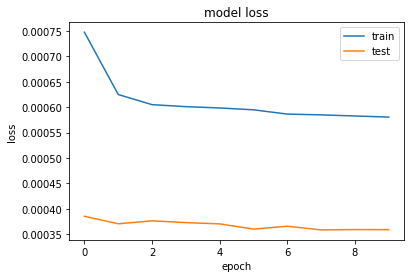

12971/12971 [==============================] - 23s 2ms/step


In [ ]:
df = df[['Global_intensity', 'Global_active_power',  'Global_reactive_power', 'Voltage', 'Sub_metering_2', 'Sub_metering_1','Sub_metering_3']]

df_resample = df.copy()
df_resample.shape 

from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 1660206
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))


from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model4 = Sequential()
model4.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
# model3.add(Dropout(0.1))
model4.add(Dense(1000))
model4.add(Dense(100))
model4.add(Dense(1))
model4.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model4.fit(train_x, train_y, epochs=10, batch_size=100, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model4.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

Mean Absolute Error: 0.409
Mean Squared Error:  0.835
Test RMSE: 0.914
R2 Score:  0.937918841969858


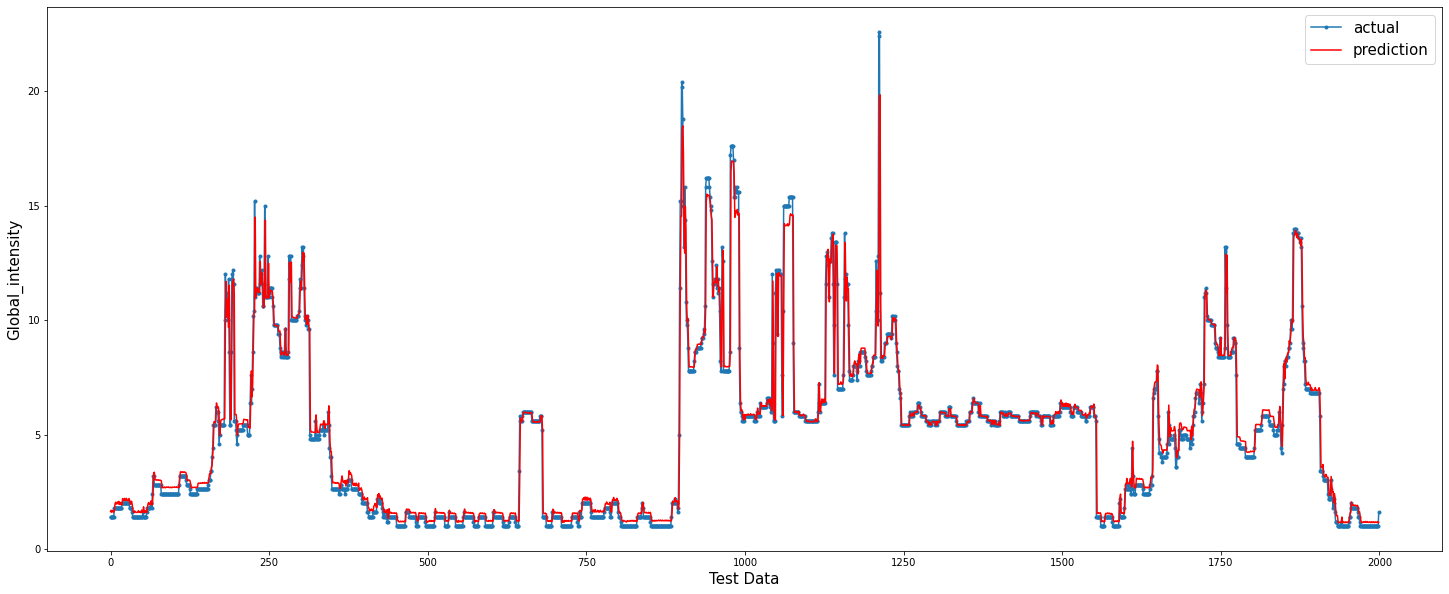

In [ ]:
# ERROR METRICES
print('Mean Absolute Error: %.3f' % mean_absolute_error(inv_y, inv_yhat)) 
print('Mean Squared Error:  %.3f' % mean_squared_error(inv_y, inv_yhat)) 
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('R2 Score: ', r2_score(inv_y, inv_yhat))

# Note that, we have resampled the database into hour, so, every time step is one hour. We try first to check the prediction in 500 hours.
aa=[x for x in range(2000)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:2000], marker='.', label="actual")
plt.plot(aa, inv_yhat[:2000], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Test Data', size=15)
plt.legend(fontsize=15)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


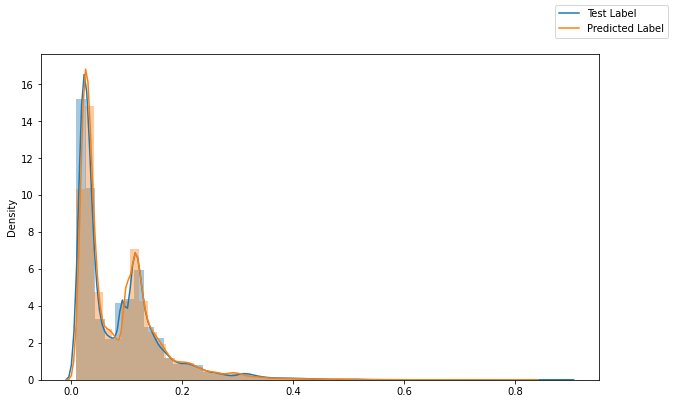

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(test_y)
sns.distplot(yhat)
fig.legend(labels=['Test Label','Predicted Label'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


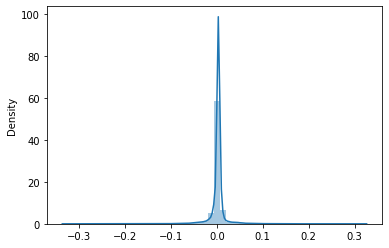

In [ ]:
sns.distplot(yhat-test_y)

In [ ]:
print("Difference of Variance = ", abs(np.var(test_y) - np.var(yhat)))

Difference of Variance =  0.00041420711762434666


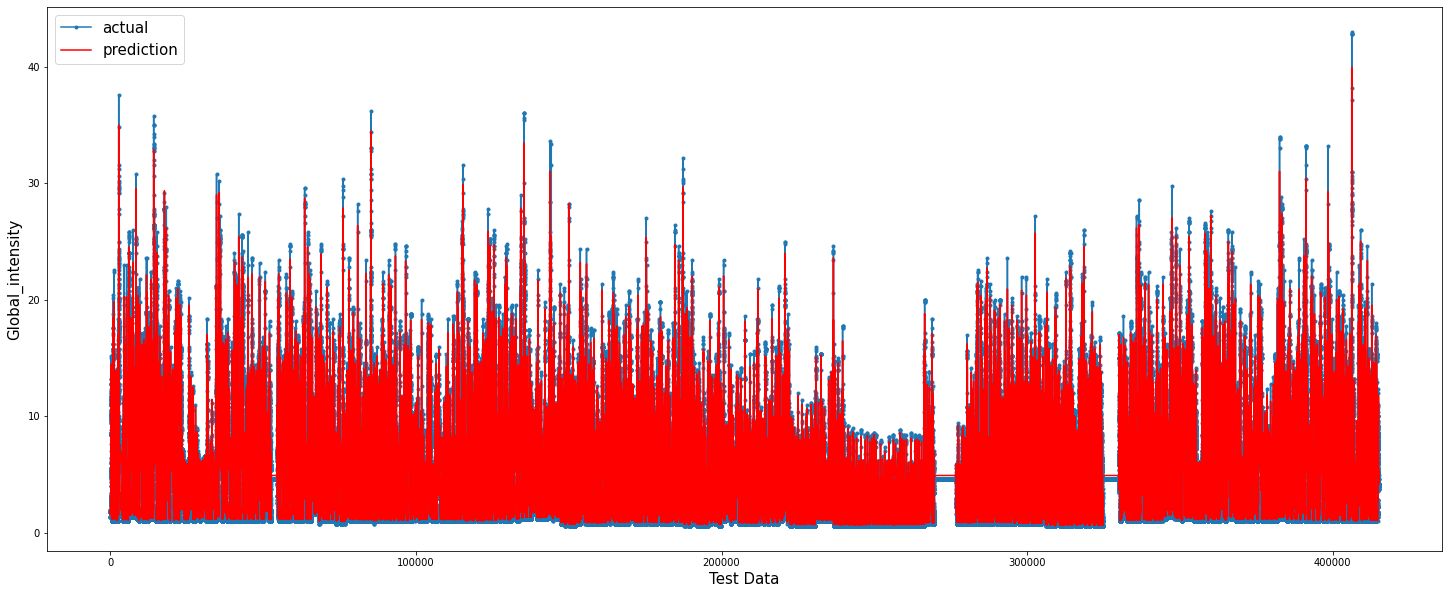

In [ ]:
kk = len(inv_yhat)
aa=[x for x in range(kk)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:kk], marker='.', label="actual")
plt.plot(aa, inv_yhat[:kk], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Test Data', size=15)
plt.legend(fontsize=15)
plt.show()

# Sub Metering 1

Epoch 1/10
16603/16603 - 63s - loss: 0.0011 - val_loss: 4.9540e-04 - 63s/epoch - 4ms/step
Epoch 2/10
16603/16603 - 58s - loss: 8.6764e-04 - val_loss: 4.9327e-04 - 58s/epoch - 4ms/step
Epoch 3/10
16603/16603 - 58s - loss: 8.4645e-04 - val_loss: 4.9077e-04 - 58s/epoch - 4ms/step
Epoch 4/10
16603/16603 - 61s - loss: 8.4199e-04 - val_loss: 4.8833e-04 - 61s/epoch - 4ms/step
Epoch 5/10
16603/16603 - 61s - loss: 8.4108e-04 - val_loss: 4.8778e-04 - 61s/epoch - 4ms/step
Epoch 6/10
16603/16603 - 61s - loss: 8.5369e-04 - val_loss: 4.8848e-04 - 61s/epoch - 4ms/step
Epoch 7/10
16603/16603 - 58s - loss: 8.3545e-04 - val_loss: 4.8654e-04 - 58s/epoch - 3ms/step
Epoch 8/10
16603/16603 - 58s - loss: 8.3542e-04 - val_loss: 4.8424e-04 - 58s/epoch - 3ms/step
Epoch 9/10
16603/16603 - 61s - loss: 8.1849e-04 - val_loss: 4.8527e-04 - 61s/epoch - 4ms/step
Epoch 10/10
16603/16603 - 58s - loss: 8.1258e-04 - val_loss: 4.8464e-04 - 58s/epoch - 3ms/step


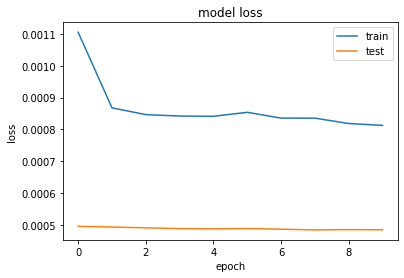

12971/12971 [==============================] - 23s 2ms/step


In [ ]:
df = df[['Sub_metering_1', 'Global_active_power',  'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_2','Sub_metering_3']]

df_resample = df.copy()

from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 1660206
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))


from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model5 = Sequential()
model5.add(LSTM(200, input_shape=(train_x.shape[1], train_x.shape[2])))
model5.add(Dense(1000))
model5.add(Dense(100))
model5.add(Dense(1))
model5.compile(loss='mean_squared_error', optimizer='adam')

# Network fitting
history = model5.fit(train_x, train_y, epochs=10, batch_size=100, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model5.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

Mean Absolute Error: 0.355
Mean Squared Error:  3.753
Test RMSE: 1.937
R2 Score:  0.8726695910247639


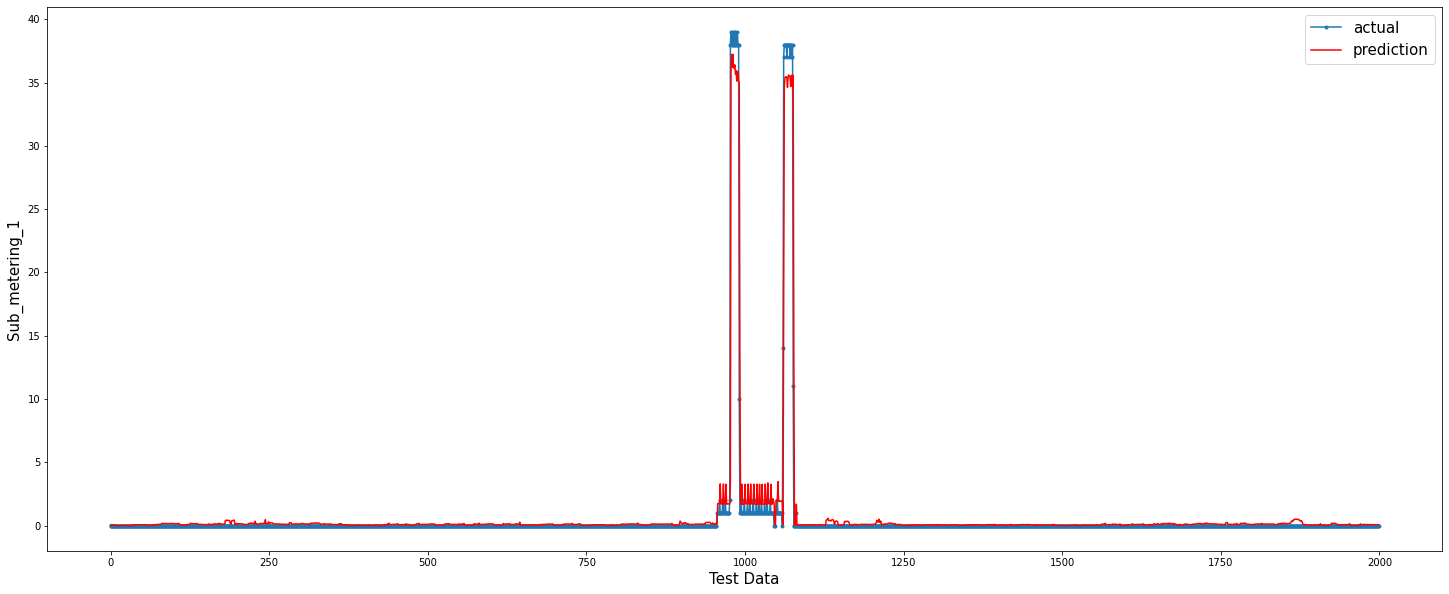

In [ ]:
# ERROR METRICES
print('Mean Absolute Error: %.3f' % mean_absolute_error(inv_y, inv_yhat)) 
print('Mean Squared Error:  %.3f' % mean_squared_error(inv_y, inv_yhat)) 
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('R2 Score: ', r2_score(inv_y, inv_yhat))


# Note that, we have resampled the database into hour, so, every time step is one hour. We try first to check the prediction in 500 hours.
aa=[x for x in range(2000)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:2000], marker='.', label="actual")
plt.plot(aa, inv_yhat[:2000], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Test Data', size=15)
plt.legend(fontsize=15)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


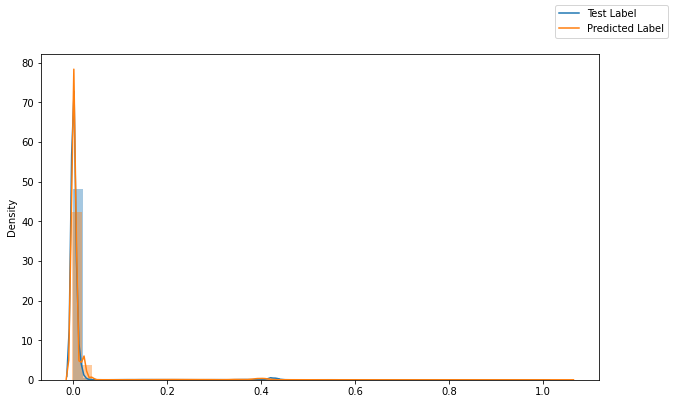

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(test_y)
sns.distplot(yhat)
fig.legend(labels=['Test Label','Predicted Label'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


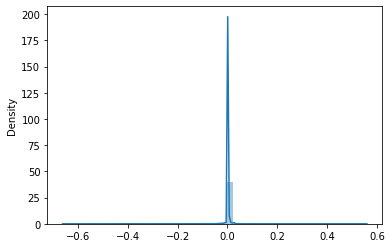

In [ ]:
sns.distplot(yhat-test_y)

In [ ]:
print("Difference of Variance = ", abs(np.var(test_y) - np.var(yhat)))

Difference of Variance =  0.00028938646149216565


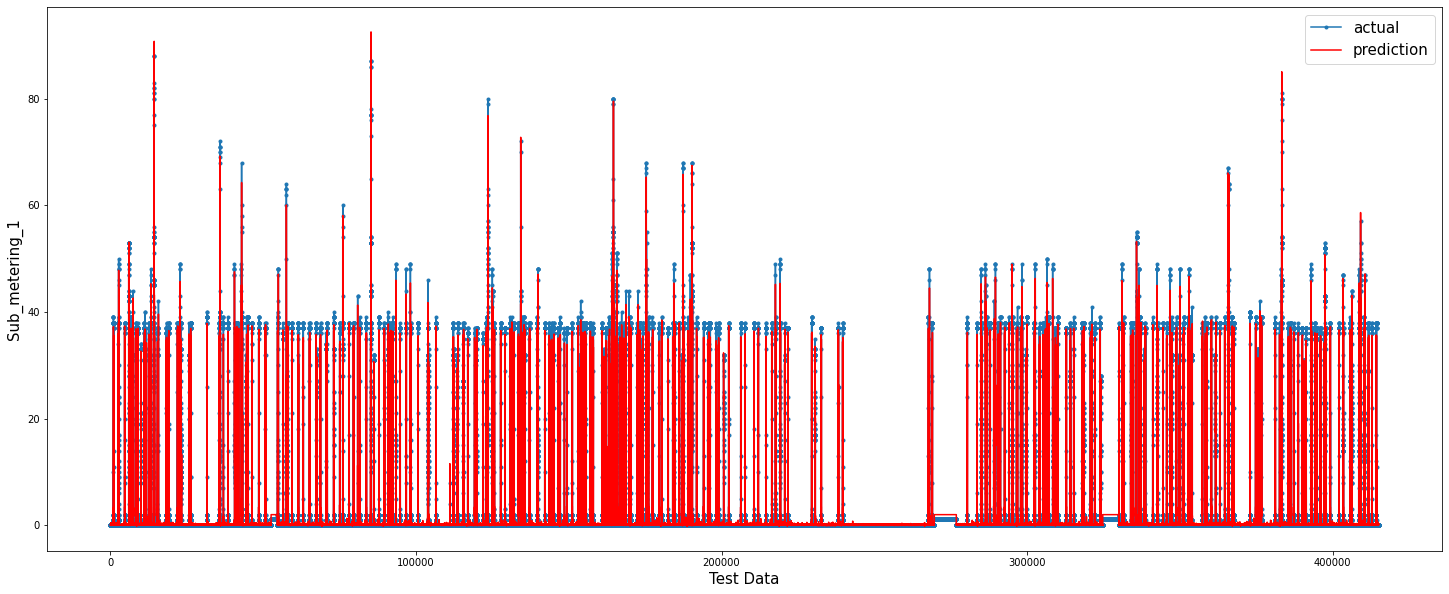

In [ ]:
kk = len(inv_yhat)
aa=[x for x in range(kk)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:kk], marker='.', label="actual")
plt.plot(aa, inv_yhat[:kk], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
# plt.xlabel('Time step for first 440 hours', size=15)
plt.xlabel('Test Data', size=15)
plt.legend(fontsize=15)
plt.show()

# Sub Metering 2

Epoch 1/15
16603/16603 - 73s - loss: 9.6393e-04 - val_loss: 4.8161e-04 - 73s/epoch - 4ms/step
Epoch 2/15
16603/16603 - 69s - loss: 7.7164e-04 - val_loss: 5.5128e-04 - 69s/epoch - 4ms/step
Epoch 3/15
16603/16603 - 66s - loss: 7.6482e-04 - val_loss: 5.5331e-04 - 66s/epoch - 4ms/step
Epoch 4/15
16603/16603 - 69s - loss: 7.6071e-04 - val_loss: 5.5017e-04 - 69s/epoch - 4ms/step
Epoch 5/15
16603/16603 - 66s - loss: 7.5074e-04 - val_loss: 5.3955e-04 - 66s/epoch - 4ms/step
Epoch 6/15
16603/16603 - 69s - loss: 7.4910e-04 - val_loss: 5.3085e-04 - 69s/epoch - 4ms/step
Epoch 7/15
16603/16603 - 66s - loss: 7.4791e-04 - val_loss: 5.2373e-04 - 66s/epoch - 4ms/step
Epoch 8/15
16603/16603 - 68s - loss: 7.4693e-04 - val_loss: 5.3094e-04 - 68s/epoch - 4ms/step
Epoch 9/15
16603/16603 - 66s - loss: 7.4778e-04 - val_loss: 5.2003e-04 - 66s/epoch - 4ms/step
Epoch 10/15
16603/16603 - 66s - loss: 7.4510e-04 - val_loss: 5.3092e-04 - 66s/epoch - 4ms/step
Epoch 11/15
16603/16603 - 68s - loss: 7.4510e-04 - val_loss

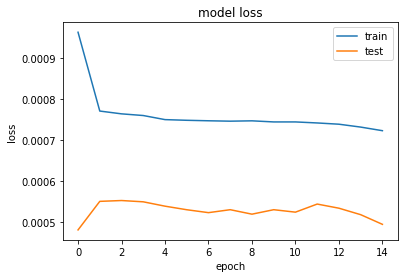

12971/12971 [==============================] - 23s 2ms/step


In [ ]:
df = df[['Sub_metering_2', 'Global_active_power',  'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1','Sub_metering_3']]

df_resample = df.copy()

from sklearn.preprocessing import MinMaxScaler

values = df_resample.values
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
reframed = series_to_supervised(scaled, 1, 1)
r = list(range(df_resample.shape[1]+1, 2*df_resample.shape[1]))
reframed.drop(reframed.columns[r], axis=1, inplace=True)
reframed.head()

# Data spliting into train and test data series. Only 4000 first data points are selected for traing purpose.
values = reframed.values
n_train_time = 1660206 
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_x, train_y = train[:, :-1], train[:, -1]
test_x, test_y = test[:, :-1], test[:, -1]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))


from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from sklearn.metrics import mean_squared_error,r2_score
import matplotlib.pyplot as plt
import numpy as np

model6 = Sequential()
model6.add(LSTM(100, input_shape=(train_x.shape[1], train_x.shape[2])))
# model3.add(Dropout(0.5))
model6.add(Dense(1000))
model6.add(Dense(100))
model6.add(Dense(1))
model6.compile(loss='mean_squared_error', optimizer='RMSprop')

# Network fitting
history = model6.fit(train_x, train_y, epochs=15, batch_size=100, validation_data=(test_x, test_y), verbose=2, shuffle=False)

# Loss history plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

size = df_resample.shape[1]

# Prediction test
yhat = model6.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], size))

# invert scaling for prediction
inv_yhat = np.concatenate((yhat, test_x[:, 1-size:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_x[:, 1-size:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

Mean Absolute Error: 0.686
Mean Squared Error:  3.169
Test RMSE: 1.780
R2 Score:  0.8631149200235865


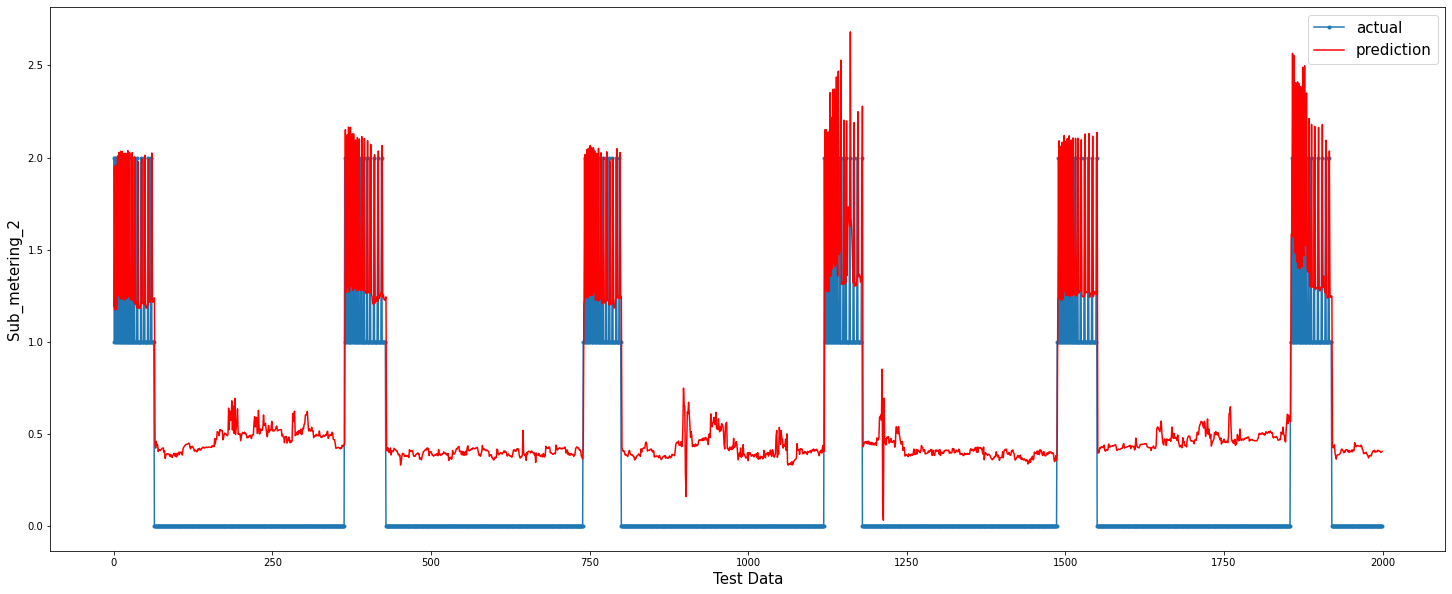

In [ ]:
# ERROR METRICES
print('Mean Absolute Error: %.3f' % mean_absolute_error(inv_y, inv_yhat)) 
print('Mean Squared Error:  %.3f' % mean_squared_error(inv_y, inv_yhat)) 
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
print('R2 Score: ', r2_score(inv_y, inv_yhat))

# Note that, we have resampled the database into hour, so, every time step is one hour. We try first to check the prediction in 500 hours.
aa=[x for x in range(2000)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:2000], marker='.', label="actual")
plt.plot(aa, inv_yhat[:2000], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
plt.xlabel('Test Data', size=15)
plt.legend(fontsize=15)
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


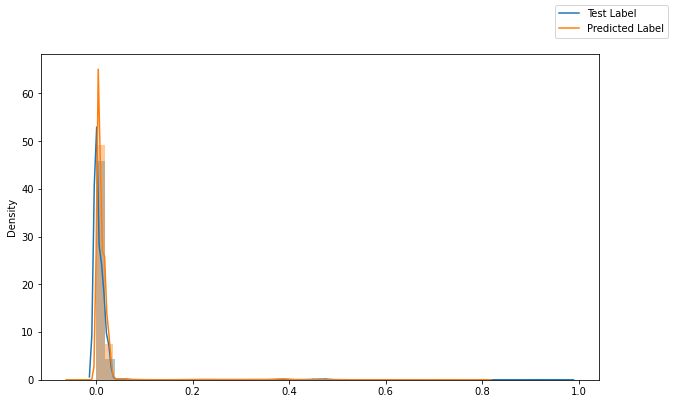

In [ ]:
fig = plt.figure(figsize=(10,6))
sns.distplot(test_y)
sns.distplot(yhat)
fig.legend(labels=['Test Label','Predicted Label'])
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


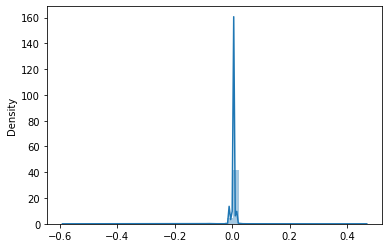

In [ ]:
sns.distplot(yhat-test_y)

In [ ]:
print("Difference of Variance = ", abs(np.var(test_y) - np.var(yhat)))

Difference of Variance =  0.0011706097962223424


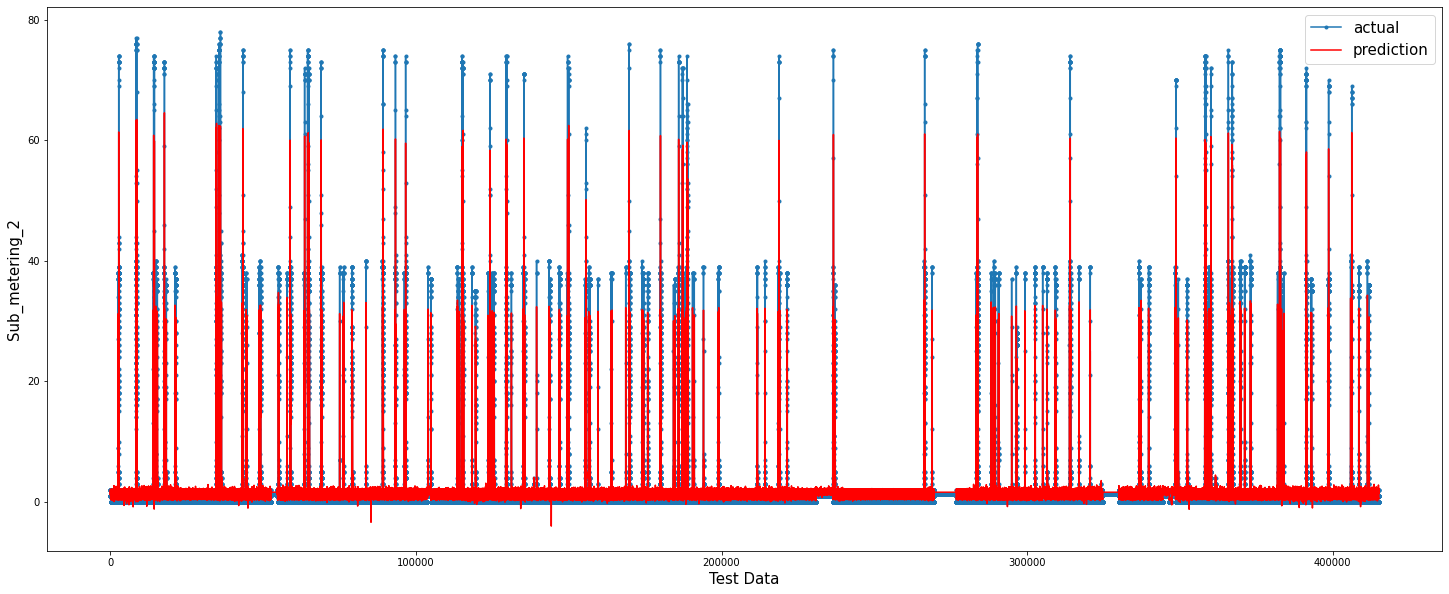

In [ ]:
kk = len(inv_yhat)
aa=[x for x in range(kk)]
plt.figure(figsize=(25,10)) 
plt.plot(aa, inv_y[:kk], marker='.', label="actual")
plt.plot(aa, inv_yhat[:kk], 'r', label="prediction")
plt.ylabel(df.columns[0], size=15)
# plt.xlabel('Time step for first 440 hours', size=15)
plt.xlabel('Test Data', size=15)
plt.legend(fontsize=15)
plt.show()

## **Conclusions:-**
In this Notebook, we practice to use the LSTM to fit and predict household electric power consumption.

Consideration of the amount of input data is important to balance model accuracy and computation cost.